## Robot Trajectory Visualizer

This code takes in the robot Cartesian position data collected while kinesthetically driving the robot to a goal position by various routes. The purpose of this data collection was to train an LSTM model to predict forces on flexible objects while being pulled around obstacles in the task-space.
The purpose of this visualizer code  was to first make sure that all areas of the task-space had been explored and to develop an algorithm for converting the trajectories from the robot's base frame to the task frame. 

In [ ]:
## Imports.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Set paths for input and output data.
file_path = '/home/ur10pc/Desktop/robot_data9/data/'
joint_data = 'joints_data.csv'
full_data = 'full_data_less_cart.csv'
cart_data = 'cart_data.csv'
all_data = 'all_data.csv'

data = pd.read_csv(file_path + all_data)

cart_pos = data[['x', 'y']]


This code divides the incoming Cartesian data into batches of size (n), which depends on the size of the trajectories, which in this case was 500 samples.

In [2]:
n=500  ## num samples per trajectory/sequence.
batches = [cart_pos[i:i + n] for i in range(0, len(cart_pos), n)] ## a list comprehension to build the data batches.
print(len(batches)) ## Given that each trajectory is of size n, how many trajectories do we have?

50


In [3]:
print(len(batches[0])) ## Confirm length of each batch/trajectory.
display(batches[0])

500


,x,y
0,-0.329250,-0.664467
1,-0.329265,-0.664474
2,-0.329210,-0.664464
3,-0.329251,-0.664458
4,-0.328578,-0.665133
...,...,...
495,0.122675,-0.618772
496,0.125567,-0.618133
497,0.126582,-0.617001
498,0.126587,-0.616923


Next we plot each trajectory using matplotlib.
Include orifice and goal positions and obstacle positions if applicable. 
The orifice was the first obstacle the flexible object (such as a flexible hose) had to pass through to reach the goal. 

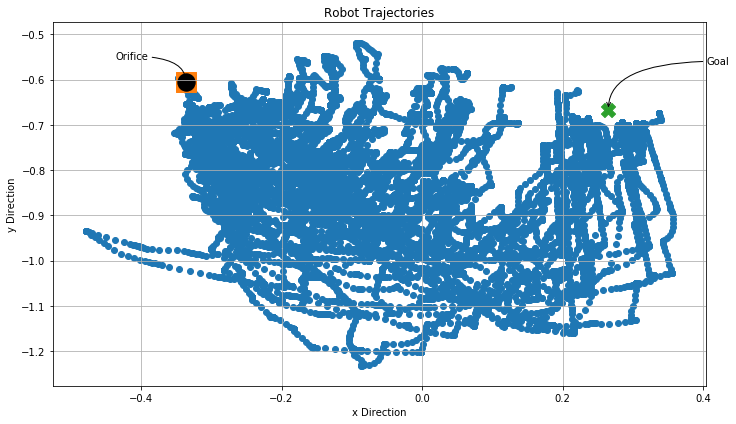

In [13]:
fig, axes = plt.subplots( figsize=(10, 6))

traj = cart_pos
x = traj[['x']]
y = traj[['y']]

plt.title('Robot Trajectories');
plt.xlabel('x Direction');
plt.ylabel('y Direction');
plt.tight_layout();
plt.grid(True)
#plt.ylim(-1, 70)
plt.scatter(x, y)

Hx, Hy = [-0.33651, -0.60491]#trajectory[0,2], trajectory[0,3]
axes.scatter(Hx, Hy, s=400, marker="s"); ## Orifice Marker
axes.scatter(Hx, Hy, s=300, marker="o", c="k"); ## Orifice Marker
axes.annotate(f'Orifice', (Hx, Hy), xytext=(Hx-0.1, Hy+0.05),arrowprops = dict(  arrowstyle="->",
                connectionstyle="angle3,angleA=0,angleB=-90"));

try:
    #bob = batch[['O1x']].to_numpy()
    #if bob[0] == True:
    ## Obstacles
    first_obstacle = batch[['O1x', 'O1y']].to_numpy()
    #batch = #2nd obs [[0.00502, -0.57675]]  #1st obs [[-0.01049, -0.6805]]
    x1, y1 = first_obstacle[0,0],first_obstacle[0,1] #base_to_task(first_obstacle).flatten()
    axes.scatter(x1, y1, s=400, marker="s");
    axes.annotate(f'Obstacle 1', (x1, y1), xytext=(x1-0.1, y1+0.05),arrowprops = dict(  arrowstyle="->",
                    connectionstyle="angle3,angleA=0,angleB=-90"));

    second_obstacle = batch[[ 'O2x', 'O2y']].to_numpy()
    x2, y2 =  second_obstacle[0,0], second_obstacle[0,1]
    #batch = #2nd obs [[0.19216, -0.57189]]  #[[0.18461, -0.55451]]
    #x2, y2 = base_to_task(second_obstacle).flatten()
    axes.scatter(x2,y2, s=400, marker="s");
    axes.annotate(f'Obstacle 2', (x2, y2), xytext=(x2-0.05, y2-0.05), arrowprops = dict(  arrowstyle="->",
                    connectionstyle="angle3,angleA=0,angleB=-90"));
except:
    pass


#batch = [[0.60914, -0.54181]]
x3, y3 = [0.26521, -0.66617]#[0.60914, -0.54181] #base_to_task(batch).flatten()
axes.scatter(x3,y3, s=200, marker="X");
axes.annotate('Goal', (x3, y3), xytext=(x3+0.14, y3+0.1), arrowprops = dict(  arrowstyle="->",
                connectionstyle="angle3,angleA=0,angleB=-90"));

plt.show()

The base-to-task function converts the robot trajectories into the task-space frame.
Once this code was working correctly, it was incorporated into the main LSTM force predictor model. 

In [94]:
def base_to_task(batch):
    """
    Rotate a point counterclockwise by a given theta around a given origin.
    The theta should be given in radians.
    """
    batch_numpy = batch.to_numpy()
    new_batch = []
    
    for row in batch_numpy:
        
        
        x = float(row[0])
        y = float(row[1])
        x+=	0.42657	#0.05  #  make the offset first then rotate.
        y+=	0.54586	#0.463
        theta = -0.215 # rotating clockwise from task to base frame.
        origin = 0,0
        point = x, y
        ox, oy = origin
        px, py = point
        qx = ox + np.cos(theta) * (px - ox) - np.sin(theta) * (py - oy)
        qy = oy + np.sin(theta) * (px - ox) + np.cos(theta) * (py - oy)

        new_batch.append([qx, qy])
        
    return np.array(new_batch)


This section plots a trajectory and confirms that the base-to-task function is working properly.
It can be seen that the trajectory in the output starts 100mm forward of the orifice located at x=0 and y=0.

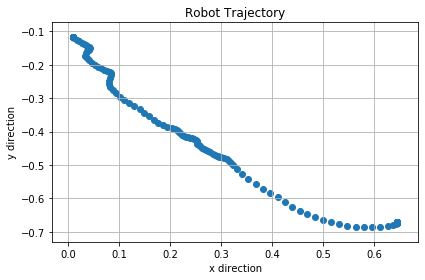

In [101]:
new_batch = base_to_task(batches[66])

traj = new_batch
x = traj[:,0]
y = traj[:,1]

plt.title('Robot Trajectory');
plt.xlabel('x direction');
plt.ylabel('y direction');
plt.tight_layout();
plt.grid(True)
#plt.ylim(-1, 70)
plt.scatter(x, y)

plt.show()